https://nextjournal.com/gkoehler/pytorch-mnist

In [ ]:
import torch
import torchvision

In [ ]:
n_epochs = 3
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [ ]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:01<00:00, 5.03MB/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 57.4kB/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:06<00:00, 245kB/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.3MB/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [ ]:
example_data.shape

torch.Size([1000, 1, 28, 28])

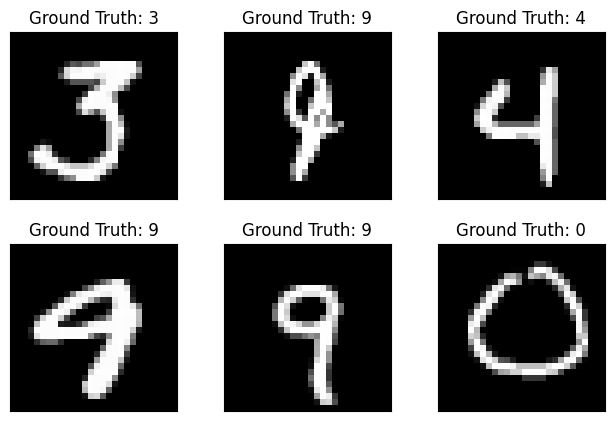

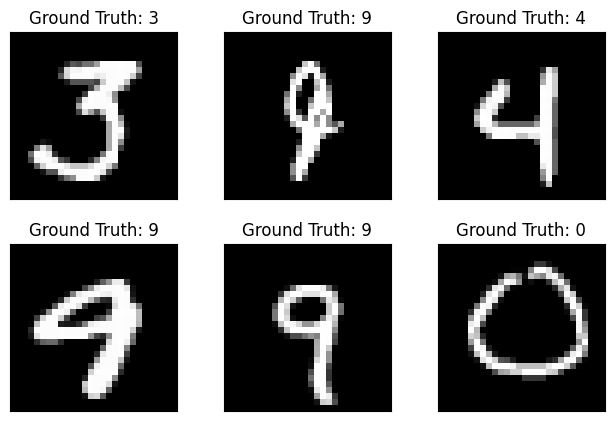

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [ ]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [ ]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs)]

In [ ]:
import os

def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      # Create the 'results' directory if it doesn't exist
      os.makedirs('/results', exist_ok=True)
      torch.save(network.state_dict(), '/results/model.pth')
      torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [ ]:
torch.save(network.state_dict(), '/results/model.pth')
torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [ ]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [ ]:
train(1)

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 1 [0/60000 (0%)]	Loss: 0.277704
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.307626
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.105479
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.611180
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.095680
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.352034
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.207174
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.201335
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.268391
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.337105
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.289237
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.109477
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.154913
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.271726
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.178456
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.347380
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.137740
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.180578
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.160105
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.153611
Train Epoch: 1 [12800/60000 (

In [ ]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0974, Accuracy: 9708/10000 (97%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.280977
Train Epoch: 1 [640/60000 (1%)]	Loss: 0.273981
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.317466
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.355507
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.311288
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.159321
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.191987
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.295647
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.211237
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.422147
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.218985
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.413123
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.157944
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.181618
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.171079
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.322534
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.309011
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.371057
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.328175
Train Epoch: 1 [12160

7
7


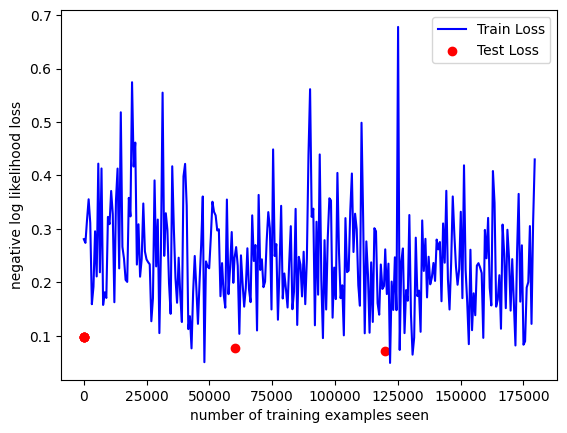

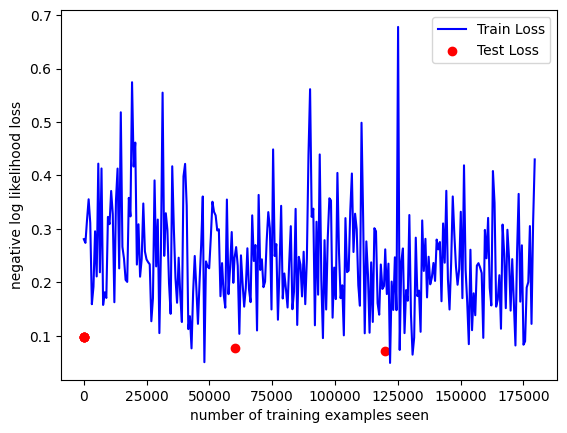

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')

# Add the initial test loss to the test_losses and test_counter lists
# This is done to ensure both lists have the same length for plotting
initial_test_loss = test_losses[0]  # Get the initial test loss
test_losses.insert(0, initial_test_loss)  # Insert it at the beginning
test_counter.insert(0, 0)  # Insert 0 at the beginning of test_counter

print(len(test_losses))
print(len(test_counter))

if len(test_losses) != len(test_counter):
    test_counter = test_counter[:len(test_losses)]

plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig

In [ ]:
with torch.no_grad():
  output = network(example_data)

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


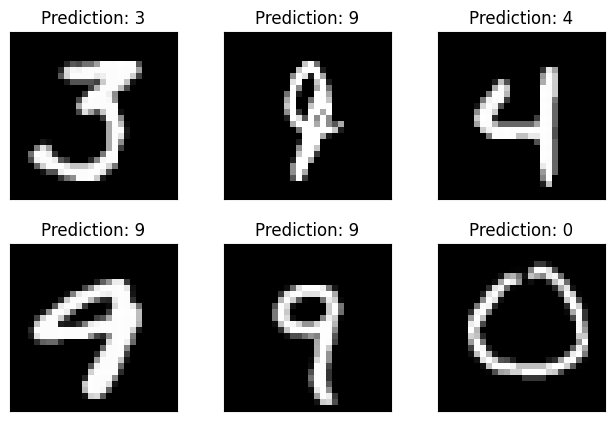

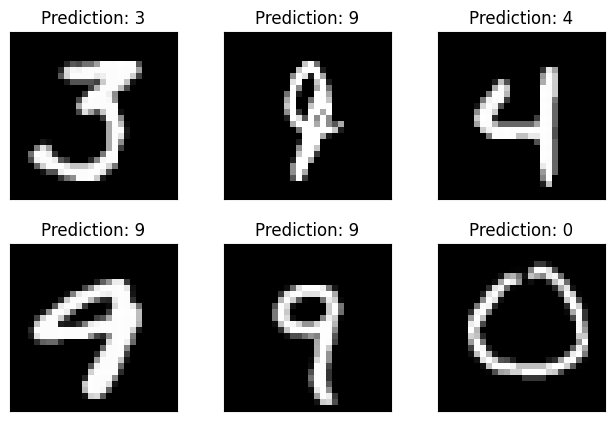

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])
fig

In [ ]:
continued_network = Net()
continued_optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                                momentum=momentum)

In [ ]:
# network_state_dict = torch.load()
continued_network.load_state_dict(network.state_dict())

# optimizer_state_dict = torch.load(optimizer.pth)
continued_optimizer.load_state_dict(optimizer.state_dict())

In [ ]:
for i in range(4,9):
  test_counter.append(i*len(train_loader.dataset))
  train(i)
  test()

<ipython-input-8-6c2218f37724>:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 4 [0/60000 (0%)]	Loss: 0.033001
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.310067
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.276041
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.153350
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.177263
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.103407
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.315189
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.098257
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.129699
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.160155
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.229129
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.207291
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.183281
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.338112
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.496023
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.239801
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.388120
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.122503
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.222986
Train Epoch: 4 [12160/60000 (20%)]	Loss: 0.110489
Train Epoch: 4 [12800/60000 (

/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0529, Accuracy: 9830/10000 (98%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.134417
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.207127
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.144154
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.092090
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.165817
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.318739
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.282121
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.214901
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.062905
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.111858
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.127044
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.138065
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.073431
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.258514
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.234516
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.088647
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.240485
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.243668
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.170905
Train Epoch: 5 [12160

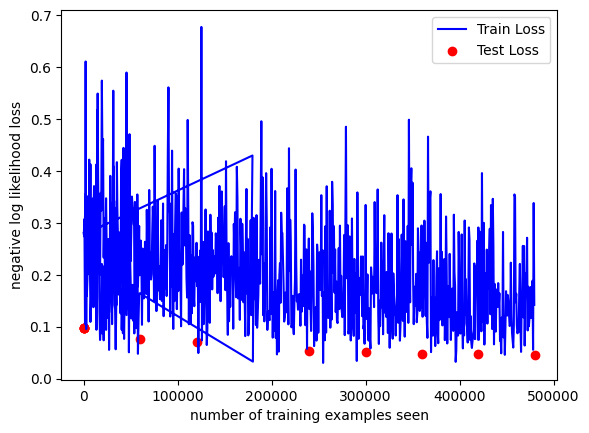

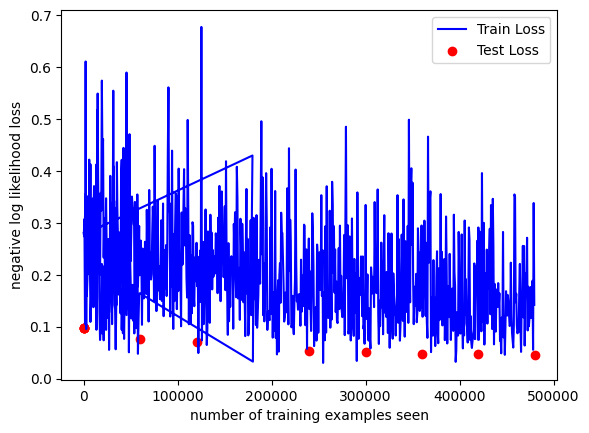

In [ ]:
fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')
fig